In [1]:
import numpy as np
import torch
import os
import cv2
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50
from google.colab import auth
from googleapiclient.discovery import build
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from torchvision import transforms

Сегодня мы будем использовать transfer learning чтобы обучить классификатор героев классических звёздных войн. Эта практика требует обучения на GPU (иначе код будет выполнятся очень долго), поэтому используйте https://colab.research.google.com.

Сначала нужно включить поддержку GPU. Зайдите в Edit -> Notebook settings и как hardware accelerator укажите GPU.

Это типичная ситуация, как у вас могут оказаться данные на руках (а не непонятный массив как было c MNIST)

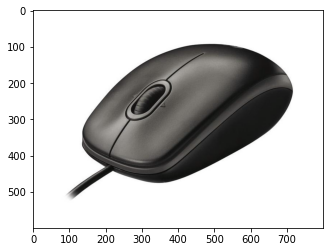

In [ ]:
img = cv2.imread("mouse_3.jpg")
plt.imshow(img)

In [2]:
filenames = []
labels = []
class_ = 0
for idx, file_name in enumerate(os.listdir()):
  if file_name == ".config" or file_name == "sample_data":
    continue
  file_name1 = file_name[:-6]
  if file_name1 == "gamepad" or file_name1[:-1] == "gamepad":
    class_ = 0
    #print(f"берем файлы \"{file_name}\" и даем им класс {class_}")
  if file_name1 == "keyboard" or file_name1[:-1] == "keyboard":
    class_ = 1
    #print(f"берем файлы \"{file_name}\" и даем им класс {class_}")
  if file_name1 == "mouse" or file_name1[:-1] == "mouse":
    class_ = 2
    #print(f"берем файлы \"{file_name}\" и даем им класс {class_}")
  filenames.append(file_name)
  labels.append(class_)
#for i in range(len(labels)):
#  print(f"Файлу \"{filenames[i]}\" даем класс {labels[i]}")
print(len(filenames))

150


In [3]:
# Задание 1. Разбейте filenames и labels на train и test части 70/30
train_filenames, test_filenames, train_labels, test_labels = train_test_split(filenames, labels, test_size=0.3, random_state=42)

Теперь нашей основной задачей является создание Dataset и Dataloader для наших данных. Их должно быть два: один для train, другой для test.

Мы собираемся использовать transfer learning - взять сеть предобученную на ImageNet и доучить её на наших изображениях. Сети тренировавшиеся на ImageNet требуют стандартного размера картинок: 224x224.

Нам нужно поресайзить картинки и делать их квадратными. Я подготовил вам два метода для ресайза и для добавление 'ушей' к изображению если оно не квадратное. Вы должны поюзать их в своем классе Dataset. 

In [4]:
def add_pad(img, shape):
    color_pick = img[0][0]
    padded_img = color_pick * np.ones(shape + img.shape[2:3], dtype=np.uint8)
    x_offset = int((padded_img.shape[0] - img.shape[0]) / 2)
    y_offset = int((padded_img.shape[1] - img.shape[1]) / 2)
    padded_img[x_offset:x_offset + img.shape[0], y_offset:y_offset + img.shape[1]] = img

    return padded_img


def resize(img, shape):
    scale = min(shape[0] * 1.0 / img.shape[0], shape[1] * 1.0 / img.shape[1])
    if scale != 1:
        img = cv2.resize(img, dsize=None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
    return img

In [5]:
import albumentations as A
import random

In [6]:
# Задание 2. Реализуйте класс-наследник Dataset. Он должен возвращать по индексу 
class StarWarsDataset(Dataset):
    def __init__(self, files, labels):
        super().__init__()   
        self.files = files
        self.labels = labels
        self.len_ = len(self.files) 
 
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = cv2.imread(str(file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
  
    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(np.array([0.485, 0.456, 0.406]), 
                                 np.array([0.229, 0.224, 0.225])) 
        ])
 
        augmentation_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p = 0.5),
            transforms.RandomRotation(7),
            transforms.Normalize(np.array([0.485, 0.456, 0.406]), 
                                 np.array([0.229, 0.224, 0.225])) 
        ])
 
 
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        
        x = transform(x)
        y = self.labels[index]
        return x, y
            
        
    def _prepare_sample(self, image):
        image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_CUBIC)
        return np.array(image)

Мы написали типичный класс-наследник Dataset для данных такого формата и поресайзили изображение к размеру 224х224 + преобразовали его в тензор внутри него. Теперь нужно создать Dataloader - да штука, которая просит возвращать Dataset данные по idx и составляет их них батчи.

In [ ]:
train_dataset[0]

(tensor([[[-2.1078, -2.1078, -2.1077,  ..., -2.1096, -2.1095, -2.1096],
          [-2.1078, -2.1078, -2.1077,  ..., -2.1095, -2.1095, -2.1095],
          [-2.1078, -2.1078, -2.1077,  ..., -2.1095, -2.1095, -2.1095],
          ...,
          [-2.1136, -2.1136, -2.1138,  ..., -2.1176, -2.1176, -2.1176],
          [-2.1132, -2.1132, -2.1133,  ..., -2.1176, -2.1176, -2.1176],
          [-2.1138, -2.1138, -2.1138,  ..., -2.1176, -2.1176, -2.1176]],
 
         [[-2.0259, -2.0259, -2.0258,  ..., -2.0279, -2.0278, -2.0279],
          [-2.0259, -2.0259, -2.0258,  ..., -2.0278, -2.0278, -2.0279],
          [-2.0259, -2.0259, -2.0258,  ..., -2.0278, -2.0278, -2.0279],
          ...,
          [-2.0300, -2.0300, -2.0301,  ..., -2.0352, -2.0352, -2.0352],
          [-2.0296, -2.0296, -2.0297,  ..., -2.0353, -2.0352, -2.0353],
          [-2.0301, -2.0301, -2.0301,  ..., -2.0353, -2.0353, -2.0353]],
 
         [[-1.7956, -1.7956, -1.7956,  ..., -1.7974, -1.7974, -1.7975],
          [-1.7956, -1.7956,

In [7]:
train_dataset = StarWarsDataset(train_filenames, train_labels)
train_dataloder = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=0)

In [8]:
# Задание 3. Сделайте dataloader для test
test_dataset = StarWarsDataset(test_filenames, test_labels)
test_dataloder = DataLoader(test_dataset, shuffle=True, batch_size=150, num_workers=0)

Завайте посмотрим что выводит ваш тестовый Dataloader...

In [14]:
# Здесь мы берем предобученный resnet34 и заменяем в нём последний слой на голову классифицирующую изображение на 1 из 3 классов
# Берём кросс энтропию в качестве лосса и оптимизатор адам
# Мы замораживаем все слои сети кроме последнего, который будем обучать далее

model = resnet50(pretrained=True) # resnet обученный на ImageNet
model = model.to("cuda")
for param in model.parameters():
  param.requires_grad=False

Как я и говорил, transfer learning - это очень просто. В resnet куча сверток и пулингов, в конце fully connected слой на 1000. Мы удаляет последний слой, заменяя его новым на с выходом на 3 класса. Так, свертки внутри модели помнят все фичи умеют распознавать классы из ImageNet, мы просто помогаем их скорректировать на наших данных  

In [15]:
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model.fc.requires_grad = True
model.to('cuda')
None

In [16]:
# loss и optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
model.train()
None

In [17]:
#Эта функция считает точность модели - на вход передается сама модель, номер эпохи и тестовый лоадер.

def run_test_on_epoch(model, epoch, test_loader):
    model.eval()
    with torch.no_grad():
      test_accuracy = []
      test_real = []
      for batch_x, batch_y in tqdm(test_loader):
          outputs = model(batch_x.float().to('cuda')).detach().cpu().numpy()
          predictions = np.argmax(outputs, axis=1)
          test_accuracy.append(outputs)
          test_real.append(batch_y.detach().cpu().numpy())
          labels = batch_y.detach().cpu().numpy()
      print("Epoch", epoch, "test accuracy", accuracy_score(predictions, labels))
    model.train()

In [ ]:
ok = 0
proceeded = 0
dim = (224, 224)
model.eval()
 
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(np.array([0.485, 0.456, 0.406]), 
                                 np.array([0.229, 0.224, 0.225])) 
        ])
 
 
for label, img_ in list(zip(test_dataset.labels, test_dataset.files)):
 
  img = cv2.imread(img_)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA).astype(float)
  img = np.array(img / 255, dtype='float32')
  img = transform(img)
 
  img = img.unsqueeze(0)
  output = model(img.to('cuda'))
  pred = torch.argmax(output)
  proceeded+=1
  ok += (pred == label)
 
ok/proceeded

tensor(0.9778, device='cuda:0')

In [ ]:
param = [1, 2, 3, 4]
param[-2]

3

In [18]:
params = list(model.parameters())
for epoch in tqdm(range(50)):
  params[-epoch].requires_grad = True
  for batch_x, batch_y in train_dataloder:

    optimizer.zero_grad()

    batch_x = batch_x.to('cuda')
    batch_y = batch_y.to('cuda')

    output = model(batch_x.float())
    loss = criterion(output, batch_y)
    loss.backward()
    optimizer.step()
    print("Loss = ", loss.item())

  run_test_on_epoch(model, epoch, test_dataloder)

  0%|          | 0/50 [00:00<?, ?it/s]

Loss =  1.2001062631607056



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  1.0904154777526855



  2%|▏         | 1/50 [00:02<01:58,  2.41s/it]

Epoch 0 test accuracy 0.6888888888888889
Loss =  0.8777086734771729



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.7793788313865662



  4%|▍         | 2/50 [00:04<01:55,  2.40s/it]

Epoch 1 test accuracy 0.8888888888888888
Loss =  0.6391714215278625



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.6603944301605225



  6%|▌         | 3/50 [00:07<01:52,  2.39s/it]

Epoch 2 test accuracy 1.0
Loss =  0.4498468041419983



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.4739128351211548



  8%|▊         | 4/50 [00:09<01:49,  2.38s/it]

Epoch 3 test accuracy 0.9777777777777777
Loss =  0.37146687507629395



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.3203432857990265



 10%|█         | 5/50 [00:11<01:48,  2.40s/it]

Epoch 4 test accuracy 0.9777777777777777
Loss =  0.31235837936401367



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.1458892524242401



 12%|█▏        | 6/50 [00:14<01:45,  2.40s/it]

Epoch 5 test accuracy 0.9777777777777777
Loss =  0.019985007122159004



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.009743014350533485



 14%|█▍        | 7/50 [00:16<01:43,  2.40s/it]

Epoch 6 test accuracy 0.9777777777777777
Loss =  0.006625594571232796



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.006429486908018589



 16%|█▌        | 8/50 [00:19<01:40,  2.40s/it]

Epoch 7 test accuracy 0.9777777777777777
Loss =  0.0010894713923335075



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.06119404733181



 18%|█▊        | 9/50 [00:21<01:38,  2.40s/it]

Epoch 8 test accuracy 0.9777777777777777
Loss =  0.0007063266239129007



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.0011008557630702853



 20%|██        | 10/50 [00:23<01:35,  2.39s/it]

Epoch 9 test accuracy 0.9777777777777777
Loss =  0.001176230376586318



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.0030968410428613424



 22%|██▏       | 11/50 [00:26<01:33,  2.39s/it]

Epoch 10 test accuracy 0.9777777777777777
Loss =  0.00041752849938347936



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.004162934608757496



 24%|██▍       | 12/50 [00:28<01:31,  2.41s/it]

Epoch 11 test accuracy 0.9777777777777777
Loss =  0.000296051730401814



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.0003341123228892684



 26%|██▌       | 13/50 [00:31<01:28,  2.40s/it]

Epoch 12 test accuracy 0.9111111111111111
Loss =  0.0006964202621020377



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.00011199140135431662



 28%|██▊       | 14/50 [00:33<01:25,  2.39s/it]

Epoch 13 test accuracy 0.8444444444444444
Loss =  0.00025261269183829427



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.0013426668010652065



 30%|███       | 15/50 [00:35<01:23,  2.38s/it]

Epoch 14 test accuracy 0.9777777777777777
Loss =  0.00011453482875367627



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.0004510916769504547



 32%|███▏      | 16/50 [00:38<01:21,  2.39s/it]

Epoch 15 test accuracy 0.9555555555555556
Loss =  0.0001904006057884544



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.0006537302979268134



 34%|███▍      | 17/50 [00:40<01:18,  2.39s/it]

Epoch 16 test accuracy 0.9555555555555556
Loss =  0.0001711279182927683



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.0016472871648147702



 36%|███▌      | 18/50 [00:43<01:16,  2.38s/it]

Epoch 17 test accuracy 0.9777777777777777
Loss =  0.00017513195052742958



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.0004263479495421052



 38%|███▊      | 19/50 [00:45<01:14,  2.39s/it]

Epoch 18 test accuracy 0.9111111111111111
Loss =  0.00019648103625513613



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.0003945240459870547



 40%|████      | 20/50 [00:47<01:11,  2.39s/it]

Epoch 19 test accuracy 0.7333333333333333
Loss =  0.00019248193711973727



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.00018919796275440603



 42%|████▏     | 21/50 [00:50<01:09,  2.39s/it]

Epoch 20 test accuracy 0.8666666666666667
Loss =  0.0006877147825434804



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.0015399657422676682



 44%|████▍     | 22/50 [00:52<01:06,  2.39s/it]

Epoch 21 test accuracy 0.9777777777777777
Loss =  0.0009719694498926401



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.016232186928391457



 46%|████▌     | 23/50 [00:55<01:04,  2.39s/it]

Epoch 22 test accuracy 0.8666666666666667
Loss =  0.00021479619317688048



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.008748535998165607



 48%|████▊     | 24/50 [00:57<01:02,  2.39s/it]

Epoch 23 test accuracy 0.9777777777777777
Loss =  0.00025301636196672916



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.09120722860097885



 50%|█████     | 25/50 [00:59<00:59,  2.39s/it]

Epoch 24 test accuracy 0.4666666666666667
Loss =  0.0006397014367394149



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.4933655858039856



 52%|█████▏    | 26/50 [01:02<00:57,  2.38s/it]

Epoch 25 test accuracy 0.37777777777777777
Loss =  0.012263939715921879



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.005437264684587717



 54%|█████▍    | 27/50 [01:04<00:54,  2.38s/it]

Epoch 26 test accuracy 0.4888888888888889
Loss =  0.0020223523024469614



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.0052244090475142



 56%|█████▌    | 28/50 [01:06<00:52,  2.38s/it]

Epoch 27 test accuracy 0.6666666666666666
Loss =  0.0008874146151356399



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.025743940845131874



 58%|█████▊    | 29/50 [01:09<00:50,  2.38s/it]

Epoch 28 test accuracy 0.7777777777777778
Loss =  0.0016946839168667793



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.0016297749243676662



 60%|██████    | 30/50 [01:11<00:48,  2.40s/it]

Epoch 29 test accuracy 0.6
Loss =  0.010369607247412205



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.0018939219880849123



 62%|██████▏   | 31/50 [01:14<00:45,  2.40s/it]

Epoch 30 test accuracy 0.6666666666666666
Loss =  0.0004373478004708886



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.0011841567466035485



 64%|██████▍   | 32/50 [01:16<00:43,  2.41s/it]

Epoch 31 test accuracy 0.8
Loss =  0.0002856359933502972



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.0002147474733646959



 66%|██████▌   | 33/50 [01:18<00:40,  2.41s/it]

Epoch 32 test accuracy 0.8666666666666667
Loss =  5.504088767338544e-05



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.00033540272852405906



 68%|██████▊   | 34/50 [01:21<00:38,  2.40s/it]

Epoch 33 test accuracy 0.8888888888888888
Loss =  5.046679871156812e-05



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.0023260603193193674



 70%|███████   | 35/50 [01:23<00:36,  2.41s/it]

Epoch 34 test accuracy 0.9333333333333333
Loss =  5.120541754877195e-05



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.00011521684791659936



 72%|███████▏  | 36/50 [01:26<00:33,  2.41s/it]

Epoch 35 test accuracy 0.9333333333333333
Loss =  0.00013440630573313683



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  9.36864162213169e-05



 74%|███████▍  | 37/50 [01:28<00:31,  2.41s/it]

Epoch 36 test accuracy 0.9333333333333333
Loss =  7.145747804315761e-05



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  6.121816841186956e-05



 76%|███████▌  | 38/50 [01:31<00:28,  2.41s/it]

Epoch 37 test accuracy 0.8666666666666667
Loss =  8.136329415719956e-05



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  7.826111686881632e-05



 78%|███████▊  | 39/50 [01:33<00:26,  2.41s/it]

Epoch 38 test accuracy 0.9555555555555556
Loss =  0.001144186593592167



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  5.592572779278271e-05



 80%|████████  | 40/50 [01:35<00:24,  2.41s/it]

Epoch 39 test accuracy 0.6444444444444445
Loss =  0.01044845674186945



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  3.58289762516506e-05



 82%|████████▏ | 41/50 [01:38<00:21,  2.42s/it]

Epoch 40 test accuracy 0.6222222222222222
Loss =  0.0059815663844347



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  9.653820598032326e-05



 84%|████████▍ | 42/50 [01:40<00:19,  2.42s/it]

Epoch 41 test accuracy 0.5111111111111111
Loss =  0.0004262066795490682



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  8.636507845949382e-05



 86%|████████▌ | 43/50 [01:43<00:17,  2.43s/it]

Epoch 42 test accuracy 0.4888888888888889
Loss =  7.260403071995825e-05



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.0009391095372848213



 88%|████████▊ | 44/50 [01:45<00:14,  2.43s/it]

Epoch 43 test accuracy 0.4888888888888889
Loss =  0.00011087431630585343



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  7.661016570637003e-05



 90%|█████████ | 45/50 [01:47<00:12,  2.42s/it]

Epoch 44 test accuracy 0.6
Loss =  9.990933176595718e-05



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  7.026455568848178e-05



 92%|█████████▏| 46/50 [01:50<00:09,  2.44s/it]

Epoch 45 test accuracy 0.6666666666666666
Loss =  3.9087917684810236e-05



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  8.022923429962248e-05



 94%|█████████▍| 47/50 [01:52<00:07,  2.43s/it]

Epoch 46 test accuracy 0.7777777777777778
Loss =  0.00014054712664801627



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  8.838772373565007e-06



 96%|█████████▌| 48/50 [01:55<00:04,  2.43s/it]

Epoch 47 test accuracy 0.8888888888888888
Loss =  2.8019785531796515e-05



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.00017255656712222844



 98%|█████████▊| 49/50 [01:57<00:02,  2.43s/it]

Epoch 48 test accuracy 0.9777777777777777
Loss =  2.7829964892589487e-05



  0%|          | 0/1 [00:00<?, ?it/s]

Loss =  0.00021300955268088728



100%|██████████| 50/50 [02:00<00:00,  2.40s/it]

Epoch 49 test accuracy 0.9777777777777777


In [ ]:
dim = (224, 224)
model.eval()
 
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(np.array([0.485, 0.456, 0.406]), 
                                 np.array([0.229, 0.224, 0.225])) 
        ])
 
img = cv2.imread("mouse_test.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA).astype(float)
img = np.array(img / 255, dtype='float32')
img = transform(img)
 
img = img.unsqueeze(0)
output = model(img.to('cuda'))
pred = torch.argmax(output)
pred

tensor(2, device='cuda:0')

In [ ]:
torch.save(model.state_dict(), "Model.pt")